#### Flow matching

Goal: train NN $u_t^{\theta}(X_t)$ with parameters ${\theta}$ to approx the target marginal vector field $u_t^{target}(X_t)$. $u_t^{\theta}(X_t)\approx u_t^{target}(X_t)$

**Flow matching loss**:
$$
\begin{aligned}
& L_{fm}(\theta)=\mathbb{E}_{(t,z,x)} \left[||u_t^{\theta}(x)-u_t^{target}(x)||^2\right]
\\
& t\sim Unif[0,1]
\\
& z\sim p_{data}
\\
& x\sim p_t(\cdot|z)
\end{aligned}
$$

*However*, $u_t^{target}(x)=\int{u_t^{target}(x|z)\frac{p_t(x|z)p_{data}}{\int{p_t(x|z)p_{data}dz}}dz}$ is intractable/expensive to compute for every call to the loss fn when the size of the dataset is large.

**Conditional flow matching loss**:
$$
\begin{aligned}
& L_{cfm}(\theta)=\mathbb{E}_{(t,z,x)} \left[||u_t^{\theta}(x)-u_t^{target}(x|z)||^2\right]
\end{aligned}
$$

*Theorem:* $L_{fm}(\theta)=L_{cfm}(\theta)+C$, where $C$ is a constant w.r.t $\theta$. Hence,
1. Minimizer $\theta^*$ of $L_{cfm}$ is the marginal vector field $u_t^{\theta^*}=u_t^{target}$,
2. Gradients of the FM and CFM loss $\nabla_{\theta}L_{cfm}(\theta)=\nabla_{\theta}L_{fm}(\theta)$ hence SGD optimization of both is the same.

**Training algo**:

Given samples $z\sim p_{data}$ and NN $u_t^{\theta}$,
1. For each mini-batch do:
    1. Sample an example $z\sim p_{data}$
    2. Sample a random time $t\sim Unif[0,1]$
    3. Sample $x\sim p_t(\cdot|z)$
    4. Compute loss:
    $$
    \begin{aligned}
    & L_{cfm}(\theta)=||u_t^{\theta}(x)-u_t^{target}(x|z)||^2
    \end{aligned}
    $$
    5. Update $\theta$ via gradient descent.

For a Gaussian *CondOT prob path*:

Given samples $z\sim p_{data}$ and NN $u_t^{\theta}$,
1. For each mini-batch do:
    1. Sample an example $z\sim p_{data}$
    2. Sample a random time $t\sim Unif[0,1]$
    3. Sample from a std Normal $\epsilon\sim\mathcal{N}(0, I_d)$
    4. $x=\alpha_t z+\beta_t \epsilon,  \alpha_t=t,  \beta_t=(1-t) \Rightarrow x=t(z-\epsilon)+\epsilon$
    5. Compute loss:
    $$
    \begin{aligned}
    & L_{cfm}(\theta)=\left \Vert u_t^{\theta}(x)-\left[\left(\dot{\alpha_t}-\frac{\dot{\beta_t}}{\beta_t}\alpha_t\right)z+\frac{\dot{\beta_t}}{\beta_t}x\right]\right \Vert^2
    \\
    & L_{cfm}(\theta)=\left \Vert u_t^{\theta}(x)-\left[\left(1+\frac{1}{\beta_t}\alpha_t\right)z-\frac{1}{\beta_t}(\alpha_t z+\beta_t \epsilon)\right]\right \Vert^2
    \\
    & L_{cfm}(\theta)=\left \Vert u_t^{\theta}(t\left[z-\epsilon\right]+\epsilon)-\left[z-\epsilon\right]\right \Vert^2
    \end{aligned}
    $$
    6. Update $\theta$ via gradient descent.

Minimizing the loss function, the NN $u^\theta$ given a noisy image and $t$, $u_t^\theta(t\left[z-\epsilon\right]+\epsilon)$, learns to predict the difference between the original image and the noise vector added to it $(z-\epsilon)$.

$(z-\epsilon)$ is also the velocity at the current $t$ along the path from the noise vector to the sample. For paths other than the straight line CondOT path, this velocity would take a different (time-dependent) form.

#### Score matching (Extension to SDEs)

Train a *Score network* $s_t^\theta(x)$ to approximate target marginal score function $s_t^{target}(x)=\nabla_x \log p_t(x)$

**Score matching loss**

$$
\begin{aligned}
& L_{sm}(\theta)=\mathbb{E}_{(t,z,x)} \left[||s_t^{\theta}(x)-\nabla_x \log p_t(x)||^2\right]
\end{aligned}
$$

$\checkmark$ Minimizer is the target marginal score fn,

$\times$ Intractable to compute the integral over a large dataset at every evaluation of the loss,

**Denoising score matching loss** (conditional version of $L_{sm}$)


$$
\begin{aligned}
& L_{dsm}(\theta)=\mathbb{E}_{(t,z,x)} \left[||s_t^{\theta}(x)-\nabla_x \log p_t(x|z)||^2\right]
\end{aligned}
$$

Same as with flow matching loss, for score matching loss $L_{sm}(\theta) = L_{dsm}(\theta) + C$, hence 1) minimizer $\theta^*$ is the same for both, 2) gradients of both loss fns are equal.

$\checkmark$ Minimizer is the target marginal score fn + constant,

$\times$ Tractable,

**Training algo**:

Given samples $z\sim p_{data}$ and score NN $s_t^{\theta}$,
1. For each mini-batch do:
    1. Sample an example $z\sim p_{data}$
    2. Sample a random time $t\sim Unif[0,1]$
    3. Sample $x\sim p_t(\cdot|z)$
    4. Compute loss:
      $$
      \begin{aligned}
      & L_{dsm}(\theta)=||s_t^{\theta}(x)-\nabla_x \log_t(x|z)||^2
      \end{aligned}
      $$
    5. Update $\theta$ via gradient descent.

**For Gaussian prob path**:

$\nabla_x \log_t(x|z)=-\frac{x-\alpha_t z}{\beta_t^2}$

Given samples $z\sim p_{data}$ and NN $u_t^{\theta}$,
1. For each mini-batch do:
    1. Sample an example $z\sim p_{data}$
    2. Sample a random time $t\sim Unif[0,1]$
    3. Sample from a std Normal $\epsilon\sim\mathcal{N}(0, I_d)$
    4. $x=\alpha_t z+\beta_t \epsilon,  \alpha_t=t,  \beta_t=(1-t) \Rightarrow x=t(z-\epsilon)+\epsilon$
    5. Compute loss:
      $$
      \begin{aligned}
      & L_{dsm}(\theta)=||s_t^{\theta}(\alpha_t z+\beta_t \epsilon)-\nabla_x \log_t(x|z)||^2
      \\
      & L_{dsm}(\theta)=\left \Vert s_t^{\theta}(\alpha_t z+\beta_t \epsilon)+\frac{\epsilon}{\beta}\right \Vert^2
      \end{aligned}
      $$
    6. Update $\theta$ via gradient descent.


- Score models learns to predict the noise (*scaled) added to the image $\frac{\epsilon}{\beta}$ hence the name denoising score matching (and denoising diffusion models).
- The $\frac{1}{\beta}$ in the above target makes the loss numerically unstable for $\beta_t\approx 0 (t\approx 1)$, hence it was suggested to reparameterize the model into a pure noise predictor NN $\epsilon_t^\theta$
$$
\epsilon_t^\theta = -\beta_t s_t^\theta(x) \Rightarrow L_{DDPM}=\mathbb{E}_{(t,z,x)} \left[||\epsilon_t^{\theta}(\alpha_t z+\beta_t\epsilon)-\epsilon||^2\right]
$$
- For the special case of denoising diffusion models (i.e. diffusion models with Gaussian prob path), both $u_t^{target}(x|z)$ and $\nabla_x \log{p_t(x|z)}$ are weighted averages of $z$ and $x$ and one can be obtained as a linear combination of the other and $z$ or $x$. Hence need to only train the score network $s_t^\theta(x)$ and use 
$$
\begin{aligned}
& u_t^\theta(x)=\left( \beta_t^2\frac{\dot{\alpha_t}}{\alpha_t}-\dot{\beta_t}\beta_t \right) s_t^\theta (x) + \frac{\dot{\alpha_t}}{\alpha_t}x
\\
& u_t^\theta(x)=-\left( \beta_t\frac{\dot{\alpha_t}}{\alpha_t}-\dot{\beta_t} \right) \left(-\beta_t s_t^\theta (x)\right) + \frac{\dot{\alpha_t}}{\alpha_t}x
\end{aligned}
$$
- To obtain samples after training simulate the SDE:
$$
X_0\sim p_{init}, dX_t=\left[ u_t^\theta(X_t) + \frac{\sigma_t^2}{2}s_t^\theta(X_t) \right]dt+\sigma_t dW_t
$$



#### Unguided (unconditional) generation of MNIST digits via both a flow and a diffusion model

In [8]:
# train simple unet model for unconditional generation of MNIST digits with both flow matching and score matching loss

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp


In [2]:
# get and preprocess mnist dataset as a tensorflow dataset
try:
  import tensorflow_datasets as tfds  # TFDS to download MNIST.
except ImportError:
  ! pip install -q tensorflow-datasets
  import tensorflow_datasets as tfds

import tensorflow as tf  # TensorFlow / `tf.data` operations.


2025-03-22 18:27:35.139341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742668055.156647   27992 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742668055.161476   27992 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [215]:
tf.random.set_seed(42)

train_epochs = 40
epoch_steps = 100
batch_size = 128

train_ds = tfds.load('mnist', split='train', as_supervised=True)
test_ds = tfds.load('mnist', split='test', as_supervised=True)

train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

train_X_ds = train_ds.map(lambda x, y: x)
test_X_ds = test_ds.map(lambda x, y: x)

train_X_ds = (train_X_ds.repeat().shuffle(8192)
              .batch(batch_size)
              .take(train_epochs * epoch_steps)
              .prefetch(tf.data.experimental.AUTOTUNE))
test_X_ds = (test_X_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE))


2025-03-23 14:48:14.882529: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


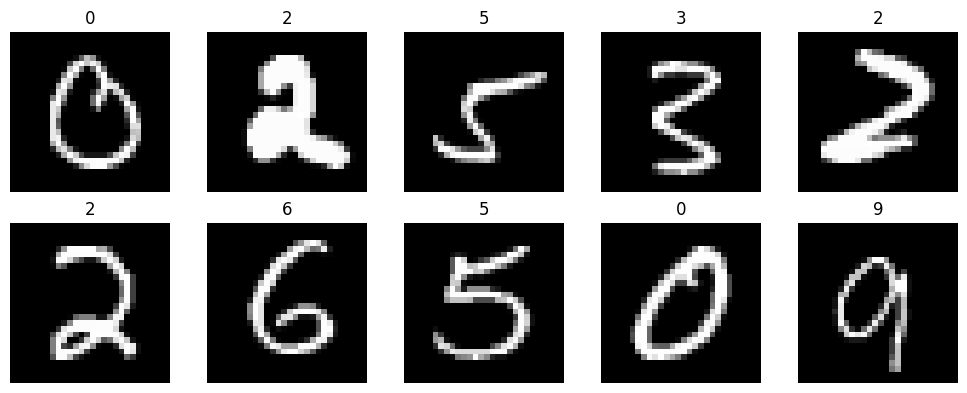

In [33]:
# display some images and labels
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
batch = next(iter(train_ds.shuffle(1024).batch(10)))
for i, ax in enumerate(axs.flat):
    x, y = batch[0][i], batch[1][i]
    ax.imshow(x.numpy().squeeze(), cmap='gray')
    ax.set_title(y.numpy())
    ax.axis('off')
plt.tight_layout()
plt.show()

In [11]:
from flax import nnx
from functools import partial


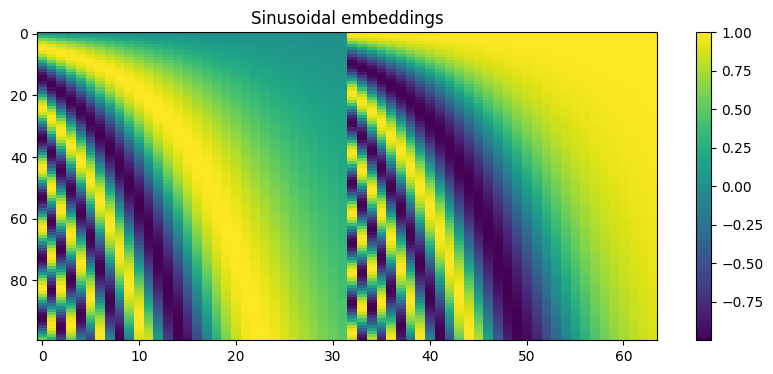

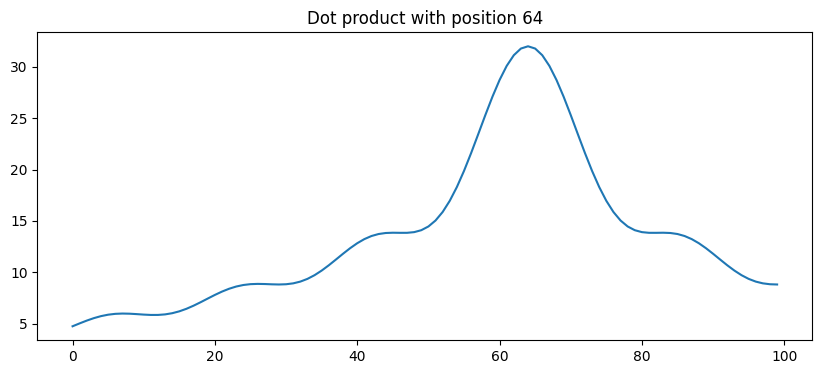

In [12]:
def get_sinusoidal_encodings(t, embedding_dim):
  half_dim = embedding_dim // 2
  emb = jnp.log(embedding_dim) / (half_dim - 1)
  emb = jnp.exp(jnp.arange(half_dim) * -emb)
  emb = half_dim * t * emb[None, :]
  emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
  return emb

# visualize sinusoidal embeddings on color scale
t = jnp.linspace(0, 1, 100).reshape(-1, 1)
emb = get_sinusoidal_encodings(t, 64)
plt.figure(figsize=(10, 4))
plt.imshow(emb, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Sinusoidal embeddings')
plt.show()

# plot dot product of sinusoidal embeddings with vector at pos 64
pos = 64
dot = jnp.dot(emb, emb[pos])
plt.figure(figsize=(10, 4))
plt.plot(dot)
plt.title(f'Dot product with position {pos}')
plt.show()


In [262]:
# UNet with ResNet blocks. Components:

# x: Image tensor
# t: Time vector
# t_sin_enc: get_sinusoidal_encodings(t)
# cond_vec: Concatenate([t_sin_enc, *other_conditional_vectors e.g. class labels])

# ConvBlock: Conv -> BatchNorm -> SiLu
# ResNetBlock: (x, cond_vecs) -> ConvBlock -> Add(Dense(cond_vec)) -> ConvBlock -> Add(x) -> x

# EncoderBlock: ResNetBlock -> ResNetBlock -> MaxPool
# Encoder: Conv2D -> [ EncoderBlock x n ]

# DecoderBlock: ConvTranspose -> ResNetBlock -> ResNetBlock
# Decoder: [ DecoderBlock x n ] -> Conv2D

# Bottleneck: ResNetBlock -> ResNetBlock

# UNetResNet: Encoder -> Bottleneck -> Decoder


class ConvBlock(nnx.Module):
  def __init__(self, *, in_feats, out_feats=None, k=3, rngs: nnx.Rngs):
    out_feats = out_feats or in_feats
    self.conv = nnx.Conv(in_feats, out_feats, kernel_size=(k, k), strides=(1, 1), padding='SAME', rngs=rngs)
    self.norm = nnx.BatchNorm(out_feats, rngs=rngs)

  def __call__(self, x, train: bool = False):
    x = self.conv(x)
    x = self.norm(x, use_running_average=not train)
    x = nnx.silu(x)
    return x
  
class ResNetBlock(nnx.Module):
  def __init__(self, *, in_feats, cond_vecs_dims, out_feats=None, k=3, rngs: nnx.Rngs):
    out_feats = out_feats or in_feats
    self.conv1 = ConvBlock(in_feats=in_feats, out_feats=out_feats, k=k, rngs=rngs)
    self.cond_vecs_dense = [nnx.Linear(cond_vec_dim, out_feats, rngs=rngs) 
                            for cond_vec_dim in cond_vecs_dims]
    self.conv2 = ConvBlock(in_feats=in_feats, out_feats=out_feats, k=k, rngs=rngs)

  def __call__(self, x, cond_vecs, train: bool = False):
    x_out = self.conv1(x, train=train)
    
    cond_vecs_emb = jnp.stack(
      [cond_vec_dense(cond_vec) 
       for cond_vec_dense, cond_vec in zip(self.cond_vecs_dense, cond_vecs)], 
      axis=-1)
    cond_vecs_emb = cond_vecs_emb.sum(axis=-1)

    x_out = x_out + cond_vecs_emb[:, None, None, :]
    
    x_out = self.conv2(x_out, train=train)
    x_out = x_out + x
    return x_out
  
class EncoderBlock(nnx.Module):
  def __init__(self, *, in_feats, cond_vecs_dims, out_feats=None, k=3, rngs: nnx.Rngs):
    out_feats = out_feats or in_feats
    self.resnet1 = ResNetBlock(in_feats=in_feats, cond_vecs_dims=cond_vecs_dims, k=k, rngs=rngs)
    self.resnet2 = ResNetBlock(in_feats=in_feats, cond_vecs_dims=cond_vecs_dims, k=k, rngs=rngs)
    self.downsample = nnx.Conv(in_feats, out_feats, kernel_size=(2, 2), strides=(2, 2), padding='VALID', rngs=rngs)

  def __call__(self, x, cond_vecs, train: bool = False):
    x = self.resnet1(x, cond_vecs)
    x = self.resnet2(x, cond_vecs)
    x = self.downsample(x)
    return x
  
class DecoderBlock(nnx.Module):
  def __init__(self, *, in_feats, cond_vecs_dims, out_feats=None, k=3, rngs: nnx.Rngs):
    out_feats = out_feats or in_feats
    self.conv_transpose = nnx.ConvTranspose(in_feats, out_feats, kernel_size=(2, 2), strides=(2, 2), padding='VALID', rngs=rngs)
    self.resnet1 = ResNetBlock(in_feats=out_feats, cond_vecs_dims=cond_vecs_dims, k=k, rngs=rngs)
    self.resnet2 = ResNetBlock(in_feats=out_feats, cond_vecs_dims=cond_vecs_dims, k=k, rngs=rngs)

  def __call__(self, x, cond_vecs, train: bool = False):
    x = self.conv_transpose(x)
    x = self.resnet1(x, cond_vecs)
    x = self.resnet2(x, cond_vecs)
    return x

class Bottleneck(nnx.Module):
  def __init__(self, *, in_feats, cond_vecs_dims, out_feats=None, k=3, rngs: nnx.Rngs):
    out_feats = out_feats or in_feats
    self.resnet1 = ResNetBlock(in_feats=in_feats, cond_vecs_dims=cond_vecs_dims, out_feats=out_feats, k=k, rngs=rngs)
    self.resnet2 = ResNetBlock(in_feats=in_feats, cond_vecs_dims=cond_vecs_dims, out_feats=out_feats, k=k, rngs=rngs)

  def __call__(self, x, cond_vecs, train: bool = False):
    x = self.resnet1(x, cond_vecs)
    x = self.resnet2(x, cond_vecs)
    return x
  
class UNetResNet(nnx.Module):
  def __init__(self, *, rngs: nnx.Rngs, in_feats=3, out_feats=1, blocks_n_feats=None, n_blocks=None, k=3, cond_vecs_dims=[64]):
    if blocks_n_feats is None:
      blocks_n_feats = [64, 128, 256, 512]
    enc_n_feats = blocks_n_feats
    dec_n_feats = blocks_n_feats[::-1]

    if n_blocks is not None and n_blocks < len(enc_n_feats):
      enc_n_feats = enc_n_feats[:n_blocks]
      dec_n_feats = dec_n_feats[-n_blocks:]
      
    bottleneck_feats = blocks_n_feats[-1]

    self.enc_n_feats = enc_n_feats
    self.dec_n_feats = dec_n_feats
    self.bottleneck_feats = bottleneck_feats

    self.input_conv = ConvBlock(in_feats=in_feats, out_feats=enc_n_feats[0], k=k, rngs=rngs)
    self.encoders = [EncoderBlock(in_feats=in_f, cond_vecs_dims=cond_vecs_dims, out_feats=out_f, k=k, rngs=rngs)
                     for (in_f, out_f) in zip(enc_n_feats, enc_n_feats[1:])]
    self.bottleneck = Bottleneck(in_feats=bottleneck_feats, cond_vecs_dims=cond_vecs_dims, out_feats=bottleneck_feats, k=k, rngs=rngs)
    self.decoders = [DecoderBlock(in_feats=in_f, cond_vecs_dims=cond_vecs_dims, out_feats=out_f, k=k, rngs=rngs)
                     for (in_f, out_f) in zip(dec_n_feats, dec_n_feats[1:])]
    self.output_conv = nnx.Conv(dec_n_feats[-1], out_feats, kernel_size=(1, 1), strides=(1, 1), padding='SAME', rngs=rngs)

  def __call__(self, x, *cond_vecs, train: bool = False):
    x = self.input_conv(x, train=train)

    skips = []
    for encoder in self.encoders:
      x = encoder(x, cond_vecs)
      skips.append(x)

    x = self.bottleneck(x, cond_vecs)

    for decoder, skip in zip(self.decoders, reversed(skips)):
      x = x + skip
      x = decoder(x, cond_vecs)
      
    output = self.output_conv(x)
    return output


class UNetResNet_t(UNetResNet):
  def __init__(self, *, time_embedding_dim=64, **kwargs):
    self.get_time_enc = partial(get_sinusoidal_encodings, embedding_dim=time_embedding_dim)
    cond_vecs_dims = [time_embedding_dim]
    super().__init__(cond_vecs_dims=cond_vecs_dims, **kwargs)
    
  def __call__(self, x, t, train: bool = False):
    t = t.reshape(-1, 1)
    t_emb = self.get_time_enc(t)
    cond_vec = t_emb
    return super().__call__(x, cond_vec, train=train)


In [263]:
model = UNetResNet_t(in_feats=1, out_feats=1, blocks_n_feats=[16, 32, 64], k=3, time_embedding_dim=64, rngs=nnx.Rngs(0))
nnx.display(model)

In [212]:
batch = next(iter(train_X_ds))
ts = jnp.zeros((batch.shape[0], 1))
print(batch.shape, ts.shape)

out_batch = model(batch, ts)
print(batch.shape, out_batch.shape)

2025-03-23 21:16:57.674508: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(128, 28, 28, 1) (128, 1)
(128, 28, 28, 1) (128, 28, 28, 1)


In [200]:
import optax

In [ ]:
learning_rate = 1e-2
momentum = 0.9

# optax.schedules.cosine_onecycle_schedule(transition_steps: int, peak_value: float, pct_start: float = 0.3, div_factor: float = 25.0, final_div_factor: float = 10000.0)

lr_schedule = optax.schedules.cosine_onecycle_schedule(
  (20)*epoch_steps, peak_value=learning_rate, 
  pct_start=5/train_epochs, div_factor=1000, final_div_factor=10.0)


In [243]:
optimizer = nnx.Optimizer(
  model, 
  optax.inject_hyperparams(optax.adamw)(lr_schedule, momentum, weight_decay=1e-7),
)
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

##### Conditional flow matching loss

In [239]:

def cfm_loss_fn(model, batch_z, batch_t, batch_e, train):
  """Compute the conditional flow matching loss."""
  # add noise to the input
  alpha_t = batch_t
  beta_t = (1 - alpha_t)
  batch_x = alpha_t * batch_z + beta_t * batch_e
  pred_e = model(batch_x, batch_t, train=train)
  target_e = (batch_z - batch_e)
  loss = optax.losses.squared_error(pred_e, target_e).mean()
  return loss

@nnx.jit
def train_step(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch, key):
  """Train for a single step."""
  batch_z = batch
  # sample t: [batch_size,1,1,1] ~ Unif[0,1] and e: batch_shape ~ N(0,1)
  batch_t = jax.random.uniform(key, [batch_z.shape[0]] + ([1]*(batch_z.ndim-1)))
  batch_e = jax.random.normal(key, batch_z.shape)

  loss, grads = nnx.value_and_grad(cfm_loss_fn, argnums=0)(model, batch_z, batch_t, batch_e, train=True)
  metrics.update(loss=loss)  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model, metrics: nnx.MultiMetric, batch, key):
  batch_z = batch
  # sample t: [batch_size,1,1,1] ~ Unif[0,1] and e: batch_shape ~ N(0,1)
  batch_t = jax.random.uniform(key, [batch_z.shape[0]] + ([1]*(batch_z.ndim-1)))
  batch_e = jax.random.normal(key, batch_z.shape)

  loss = cfm_loss_fn(model, batch_z, batch_t, batch_e, train=False)
  metrics.update(loss=loss)  # In-place updates.

In [204]:
key = jax.random.PRNGKey(0) 
train_step(model, optimizer, metrics, batch.numpy(), key)

In [ ]:
# train the model

metrics_history = {
  'train_loss': [],
  'test_loss': [],
}

key = jax.random.PRNGKey(0)


for step, batch in enumerate(train_X_ds):
  key, subkey = jax.random.split(key)
  train_step(model, optimizer, metrics, batch.numpy(), subkey)

  if step % epoch_steps == 0:
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_X_ds:
      key, subkey = jax.random.split(key)
      eval_step(model, metrics, test_batch.numpy(), subkey)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()

    step_lr = optimizer.opt_state.hyperparams['learning_rate']
    print(f'Step {step}/{len(train_X_ds)}, train loss: {metrics_history["train_loss"][-1]}, test loss: {metrics_history["test_loss"][-1]}, lr: {step_lr.item():.6g}')


Step 0/4000, train loss: 3.048163414001465, test loss: 2.397965908050537
Step 100/4000, train loss: 1.6777441501617432, test loss: 0.9496051669120789
Step 200/4000, train loss: 0.6729323863983154, test loss: 0.4822077751159668
Step 300/4000, train loss: 0.37834689021110535, test loss: 0.3092168867588043
Step 400/4000, train loss: 0.27144184708595276, test loss: 0.2536787688732147
Step 500/4000, train loss: 0.21150441467761993, test loss: 0.19040001928806305
Step 600/4000, train loss: 0.17774154245853424, test loss: 0.15999965369701385
Step 700/4000, train loss: 0.16070491075515747, test loss: 0.15196043252944946
Step 800/4000, train loss: 0.14701129496097565, test loss: 0.13943126797676086
Step 900/4000, train loss: 0.1420464813709259, test loss: 0.13590262830257416
Step 1000/4000, train loss: 0.13345187902450562, test loss: 0.12581174075603485
Step 1100/4000, train loss: 0.12920592725276947, test loss: 0.12448034435510635
Step 1200/4000, train loss: 0.1240592673420906, test loss: 0.12

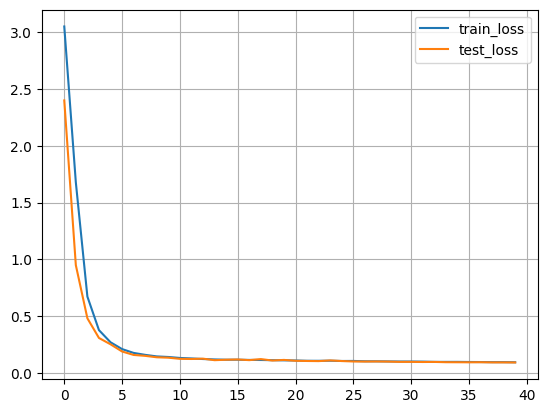

In [221]:
# plot the training and test loss
for metric, values in metrics_history.items():
  plt.plot(values, label=metric)
plt.legend()
plt.grid()
plt.show()

In [222]:
n_steps = 100
h = 1/n_steps
ts = jnp.arange(0, 1+h, h)
# ts = ts.at[-1].set(ts[-1] - 1e-3)

def euler_step(x, t, h):
  x_th = x + h*model(x, t)
  return x_th, x_th

n_samples = 20
samples_shape = [n_samples] + list(batch.shape[1:])
x0s = jax.random.normal(key, samples_shape)

# repeat n_samples times to shape [n_samples x n_steps+1]
ts = jnp.repeat(ts[None, :], n_samples, 0)

def trajectories_final(x0s, ts):
  """ Return the final states of the trajectories. """
  return jax.lax.scan(lambda x, t: euler_step(x, t, h), x0s, ts.T)[0]

samples = trajectories_final(x0s, ts)
samples.shape


(20, 28, 28, 1)

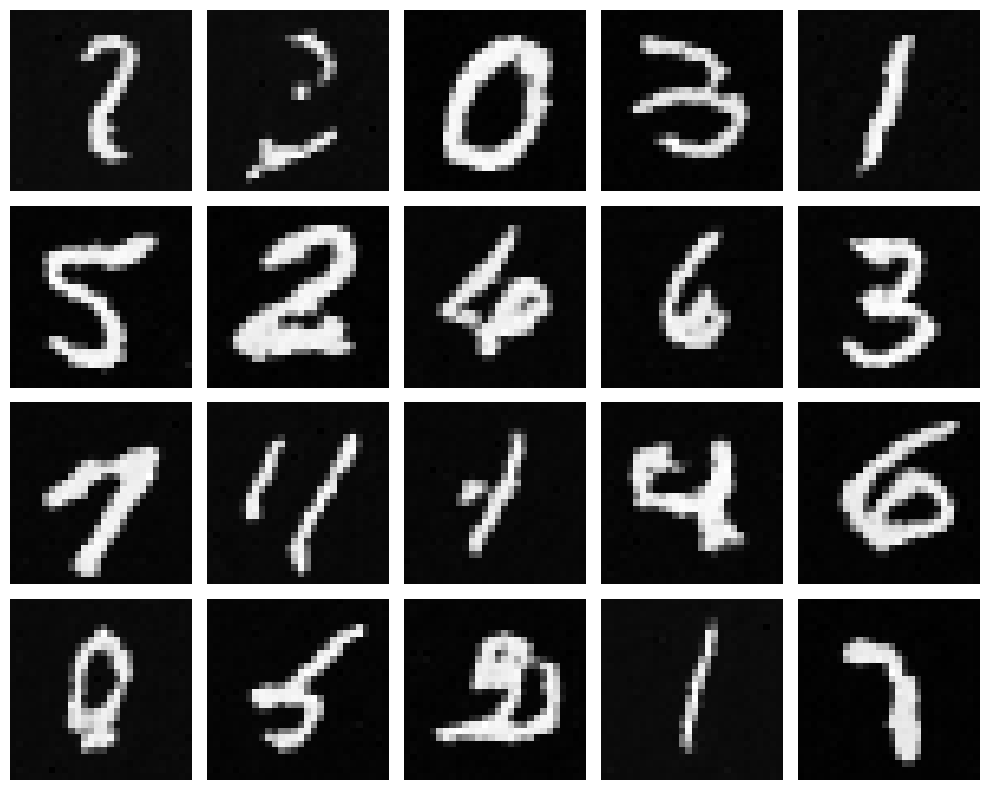

In [223]:
n_cols = int(np.ceil(np.sqrt(n_samples)))
n_rows = int(np.ceil(n_samples / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for i, ax in enumerate(axs.flat):
  if i < n_samples:
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

##### Conditional score matching loss (reparameterized Denoising Diffusion Model)

In [79]:

def csm_loss_fn(model, batch_z, batch_t, batch_e, train):
  """Compute the conditional score matching loss ||e_t(x) - e||^2 
      where e_t is a reparamaterized score network e_t(x) = -b_t*s_t(x)."""
  # add noise to the input
  alpha_t = batch_t
  beta_t = (1 - alpha_t)
  batch_x = alpha_t * batch_z + beta_t * batch_e
  pred_e = model(batch_x, batch_t, train=train)
  target_e = batch_e
  loss = optax.losses.squared_error(pred_e, target_e).mean()
  return loss

@nnx.jit
def train_step_csm(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch, key):
  """Train for a single step."""
  batch_z = batch
  # sample t: [batch_size,1,1,1] ~ Unif[0,1] and e: batch_shape ~ N(0,1)
  batch_t = jax.random.uniform(key, [batch_z.shape[0]] + ([1]*(batch_z.ndim-1)))
  batch_e = jax.random.normal(key, batch_z.shape)

  loss, grads = nnx.value_and_grad(csm_loss_fn, argnums=0)(model, batch_z, batch_t, batch_e, train=True)
  metrics.update(loss=loss)  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step_csm(model, metrics: nnx.MultiMetric, batch, key):
  batch_z = batch
  # sample t: [batch_size,1,1,1] ~ Unif[0,1] and e: batch_shape ~ N(0,1)
  batch_t = jax.random.uniform(key, [batch_z.shape[0]] + ([1]*(batch_z.ndim-1)))
  batch_e = jax.random.normal(key, batch_z.shape)

  loss = csm_loss_fn(model, batch_z, batch_t, batch_e, train=False)
  metrics.update(loss=loss)  # In-place updates.

In [80]:
# model, optimizer
model = UNetResNet_t(in_feats=1, out_feats=1, blocks_n_feats=[16, 32, 64], k=3, time_embedding_dim=64, rngs=nnx.Rngs(0))
nnx.display(model)

optimizer = nnx.Optimizer(model, optax.adamw(lr_schedule, momentum))
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

In [81]:
# train the model

metrics_history = {
  'train_loss': [],
  'test_loss': [],
}

key = jax.random.PRNGKey(0)

for step, batch in enumerate(train_X_ds):
  key, subkey = jax.random.split(key)
  train_step_csm(model, optimizer, metrics, batch.numpy(), subkey)

  if step % epoch_steps == 0:
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_X_ds:
      key, subkey = jax.random.split(key)
      eval_step_csm(model, metrics, test_batch.numpy(), subkey)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()

    print(f'Step {step}/{len(train_X_ds)}, train loss: {metrics_history["train_loss"][-1]}, test loss: {metrics_history["test_loss"][-1]}')


Step 0/3000, train loss: 3.0544474124908447, test loss: 2.5179028511047363
Step 100/3000, train loss: 2.0977447032928467, test loss: 1.1398340463638306
Step 200/3000, train loss: 0.8525559902191162, test loss: 0.5646958351135254
Step 300/3000, train loss: 0.4022693932056427, test loss: 0.2927284836769104
Step 400/3000, train loss: 0.2378312647342682, test loss: 0.1993998885154724
Step 500/3000, train loss: 0.18167708814144135, test loss: 0.15222838521003723
Step 600/3000, train loss: 0.13483214378356934, test loss: 0.11797128617763519
Step 700/3000, train loss: 0.11587726324796677, test loss: 0.09867874532938004
Step 800/3000, train loss: 0.09145879745483398, test loss: 0.0850924625992775
Step 900/3000, train loss: 0.08577313274145126, test loss: 0.08539270609617233
Step 1000/3000, train loss: 0.07843443006277084, test loss: 0.08475930243730545
Step 1100/3000, train loss: 0.07651674002408981, test loss: 0.06722796708345413
Step 1200/3000, train loss: 0.07500586658716202, test loss: 0.0

In [188]:
n_steps = 200
h = 1/n_steps
ts = jnp.arange(0, 1+h, h)

def euler_maruyama_step(x, te, h, sigma_t):
  t, e = te
  t = t[:, None, None, None]
  alpha_t = t
  beta_t = (1 - t)

  dW = jnp.sqrt(h)*e

  eps = 1e-2

  e_t = model(x, t, train=False)
  s_t = - e_t/beta_t.clip(eps, 1)
  u_t = ( (beta_t**2)/alpha_t.clip(eps, 1) + beta_t + jnp.square(sigma_t)/2 )*s_t + x/alpha_t.clip(eps, 1)

  x_th = x + h*u_t + sigma_t*dW
  return x_th, x_th

key = jax.random.PRNGKey(3)

n_samples = 20
samples_shape = [n_samples] + list(batch.shape[1:])

key, subkey = jax.random.split(key)
x0s = jax.random.normal(subkey, samples_shape)

# repeat n_samples times to shape [n_samples x n_steps+1]
ts = jnp.repeat(ts[None, :], n_samples, 0)

key, subkey = jax.random.split(key)
es = jax.random.normal(subkey, [ts.shape[1]] + list(x0s.shape)) # sample random increments e from a normal distribution outside the step function

sigma_t = 0.1

def trajectories_final(x0s, ts, es):
  """ Return the final states of the trajectories. """
  return jax.lax.scan(lambda x, te: euler_maruyama_step(x, te, h, sigma_t), x0s, (ts.T, es))[0]

samples = trajectories_final(x0s, ts, es)

x0s.shape, ts.shape, es.shape, samples.shape


((20, 28, 28, 1), (20, 201), (201, 20, 28, 28, 1), (20, 28, 28, 1))

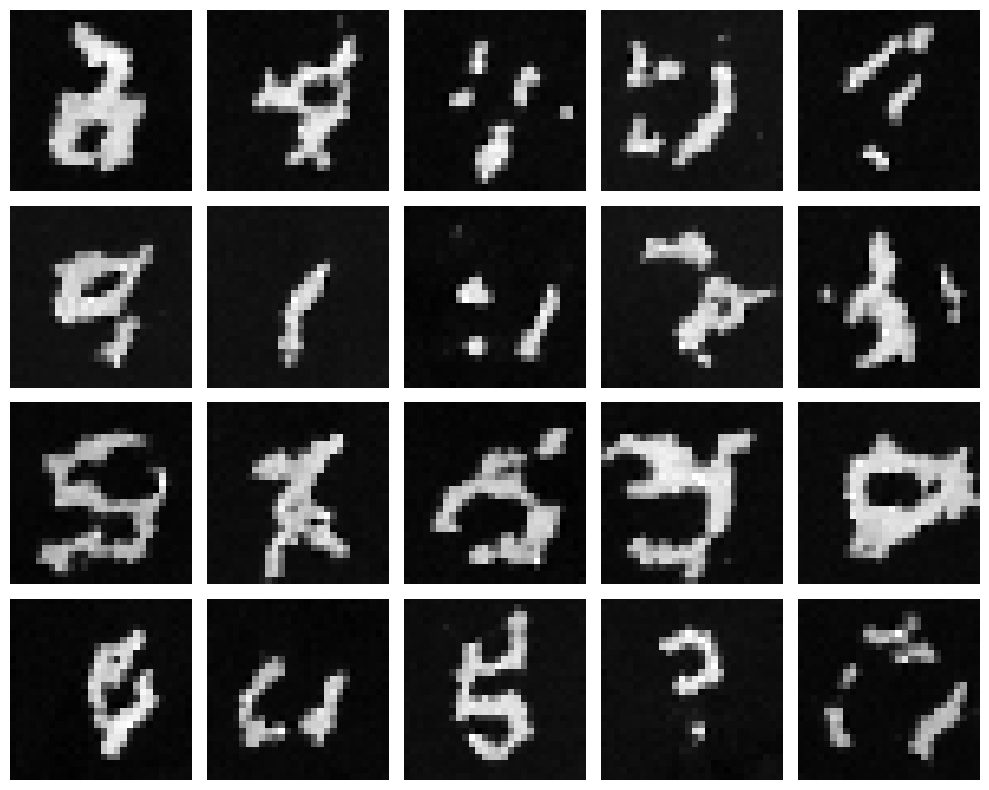

In [189]:
n_cols = int(np.ceil(np.sqrt(n_samples)))
n_rows = int(np.ceil(n_samples / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for i, ax in enumerate(axs.flat):
  if i < n_samples:
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Guided (Conditional on class labels) generation


**Conditional flow matching loss**:

Sample (image, label) from dataset,
$$
\begin{aligned}
& L_{cfm}^{guided}(\theta)=\mathbb{E}_{(t,(z,y),x)} \left[||u_t^{\theta}(x|y)-u_t^{target}(x|z)||^2\right]
\\
& (z,y)\sim p_{data}, t\sim Unif[0,1], x\sim p_t(x|z)
\end{aligned}
$$


In [ ]:
tf.random.set_seed(42)

train_epochs = 40
epoch_steps = 100
batch_size = 128

train_ds = tfds.load('mnist', split='train', as_supervised=True)
test_ds = tfds.load('mnist', split='test', as_supervised=True)

train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))

train_Xy_ds = (train_ds.repeat().shuffle(8192)
              .batch(batch_size)
              .take(train_epochs * epoch_steps)
              .prefetch(tf.data.experimental.AUTOTUNE))
test_Xy_ds = (test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE))


2025-03-23 22:48:10.361292: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


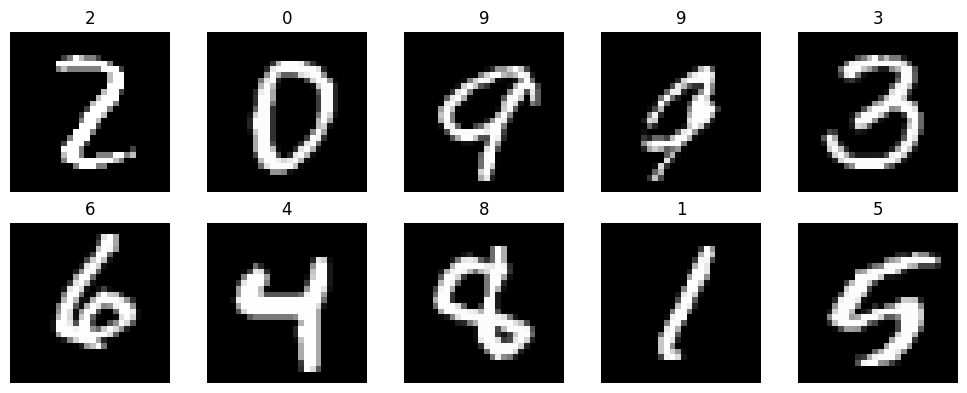

In [246]:
# display some images and labels
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
batch = next(iter(train_Xy_ds))
for i, ax in enumerate(axs.flat):
    x, y = batch[0][i], batch[1][i]
    ax.imshow(x.numpy().squeeze(), cmap='gray')
    ax.set_title(y.numpy())
    ax.axis('off')
plt.tight_layout()
plt.show()

In [267]:
class UNetResNet_t_y(UNetResNet):
  def __init__(self, *, time_embedding_dim=64, y_num_classes=10, **kwargs):
    self.get_time_enc = partial(get_sinusoidal_encodings, embedding_dim=time_embedding_dim)
    self.y_onehot = partial(jax.nn.one_hot, num_classes=y_num_classes)
    cond_vecs_dims = [time_embedding_dim, y_num_classes]
    super().__init__(cond_vecs_dims=cond_vecs_dims, **kwargs)
    
  def __call__(self, x, t, y, train: bool = False):
    t = t.reshape(-1, 1)
    t_emb = self.get_time_enc(t)

    y = y.reshape(-1)
    y_enc = self.y_onehot(y)

    return super().__call__(x, t_emb, y_enc, train=train)

In [268]:
model = UNetResNet_t_y(in_feats=1, out_feats=1, blocks_n_feats=[16, 32, 64], k=3, time_embedding_dim=64, y_num_classes=10, rngs=nnx.Rngs(0))
nnx.display(model)

In [269]:
batch = next(iter(train_Xy_ds))
batch_z, batch_y = batch
ts = jnp.zeros((batch_z.shape[0], 1))
print(batch_z.shape, batch_y.shape, ts.shape)

out_batch = model(batch_z, ts, batch_y.numpy())
print(out_batch.shape)

(64, 28, 28, 1) (64,) (64, 1)
(64, 28, 28, 1)


2025-03-23 22:57:21.599855: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [279]:
def guided_cfm_loss_fn(model, batch_z, batch_y, batch_t, batch_e, train):
  """Compute the conditional flow matching loss."""
  # add noise to the input
  alpha_t = batch_t
  beta_t = (1 - alpha_t)
  batch_x = alpha_t * batch_z + beta_t * batch_e
  pred_e = model(batch_x, batch_t, batch_y, train=train)
  target_e = (batch_z - batch_e)
  loss = optax.losses.squared_error(pred_e, target_e).mean()
  return loss

@nnx.jit
def train_step_guided(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch_z, batch_y, key):
  """Train for a single step."""
  # sample t: [batch_size,1,1,1] ~ Unif[0,1] and e: batch_shape ~ N(0,1)
  batch_t = jax.random.uniform(key, [batch_z.shape[0]] + ([1]*(batch_z.ndim-1)))
  batch_e = jax.random.normal(key, batch_z.shape)

  loss, grads = nnx.value_and_grad(guided_cfm_loss_fn, argnums=0)(model, batch_z, batch_y, batch_t, batch_e, train=True)
  metrics.update(loss=loss)  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step_guided(model, metrics: nnx.MultiMetric, batch_z, batch_y, key):
  # sample t: [batch_size,1,1,1] ~ Unif[0,1] and e: batch_shape ~ N(0,1)
  batch_t = jax.random.uniform(key, [batch_z.shape[0]] + ([1]*(batch_z.ndim-1)))
  batch_e = jax.random.normal(key, batch_z.shape)

  loss = guided_cfm_loss_fn(model, batch_z, batch_y, batch_t, batch_e, train=False)
  metrics.update(loss=loss)  # In-place updates.

In [ ]:
learning_rate = 1e-2
momentum = 0.9

# optax.schedules.cosine_onecycle_schedule(transition_steps: int, peak_value: float, pct_start: float = 0.3, div_factor: float = 25.0, final_div_factor: float = 10000.0)

lr_schedule = optax.schedules.cosine_onecycle_schedule(
  (20)*epoch_steps, peak_value=learning_rate, 
  pct_start=5/train_epochs, div_factor=1000, final_div_factor=10.0)


In [276]:
optimizer = nnx.Optimizer(
  model, 
  optax.inject_hyperparams(optax.adamw)(lr_schedule, momentum, weight_decay=1e-7),
)
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

In [ ]:
# train the model

metrics_history = {
  'train_loss': [],
  'test_loss': [],
}

key = jax.random.PRNGKey(0)

for step, batch in enumerate(train_Xy_ds):
  key, subkey = jax.random.split(key)
  batch_z, batch_y = batch
  batch_z, batch_y = batch_z.numpy(), batch_y.numpy()
  train_step_guided(model, optimizer, metrics, batch_z, batch_y, subkey)

  if step % epoch_steps == 0:
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_Xy_ds:
      key, subkey = jax.random.split(key)
      test_batch_z, test_batch_y = test_batch
      test_batch_z, test_batch_y = test_batch_z.numpy(), test_batch_y.numpy()
      eval_step_guided(model, metrics, test_batch_z, test_batch_y, subkey)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()

    step_lr = optimizer.opt_state.hyperparams['learning_rate']
    print(f'Step {step}/{len(train_Xy_ds)}, train loss: {metrics_history["train_loss"][-1]}, test loss: {metrics_history["test_loss"][-1]}, lr: {step_lr.item()}')


Step 0/4000, train loss: 3.4173736572265625, test loss: 2.638545274734497, lr: 9.999610483646393e-06
Step 100/4000, train loss: 0.9126632213592529, test loss: 0.2966688573360443, lr: 0.008557794615626335
Step 200/4000, train loss: 0.2088770717382431, test loss: 0.17874358594417572, lr: 0.00985338632017374
Step 300/4000, train loss: 0.1591820865869522, test loss: 0.1769677847623825, lr: 0.00911223515868187
Step 400/4000, train loss: 0.14193123579025269, test loss: 0.16261063516139984, lr: 0.007837098091840744
Step 500/4000, train loss: 0.13437634706497192, test loss: 0.12930332124233246, lr: 0.006193575449287891
Step 600/4000, train loss: 0.1252070814371109, test loss: 0.12344362586736679, lr: 0.004395110532641411
Step 700/4000, train loss: 0.12151863425970078, test loss: 0.11394461989402771, lr: 0.002675265772268176
Step 800/4000, train loss: 0.11562640219926834, test loss: 0.11215036362409592, lr: 0.001257396535947919
Step 900/4000, train loss: 0.11419942229986191, test loss: 0.109883

In [281]:
import math


In [287]:
n_steps = 200
h = 1/n_steps
ts = jnp.arange(0, 1+h, h)
# ts = ts.at[-1].set(ts[-1] - 1e-3)

def euler_step(x, t, y, h):
  x_th = x + h*model(x, t, y)
  return x_th, x_th

n_samples = 20
sample_classes = jnp.arange(10, dtype=jnp.int32)
sample_classes = jnp.tile(sample_classes, math.ceil(n_samples/sample_classes.shape[0]))[:n_samples]

samples_shape = [n_samples] + list(batch_z.shape[1:])
x0s = jax.random.normal(key, samples_shape)

# repeat n_samples times to shape [n_samples x n_steps+1]
ts = jnp.repeat(ts[None, :], n_samples, 0)

def trajectories_final(x0s, ts, y):
  """ Return the final states of the trajectories. """
  return jax.lax.scan(lambda x, t: euler_step(x, t, y, h), x0s, ts.T)[0]

samples = trajectories_final(x0s, ts, sample_classes)
samples.shape


(20, 28, 28, 1)

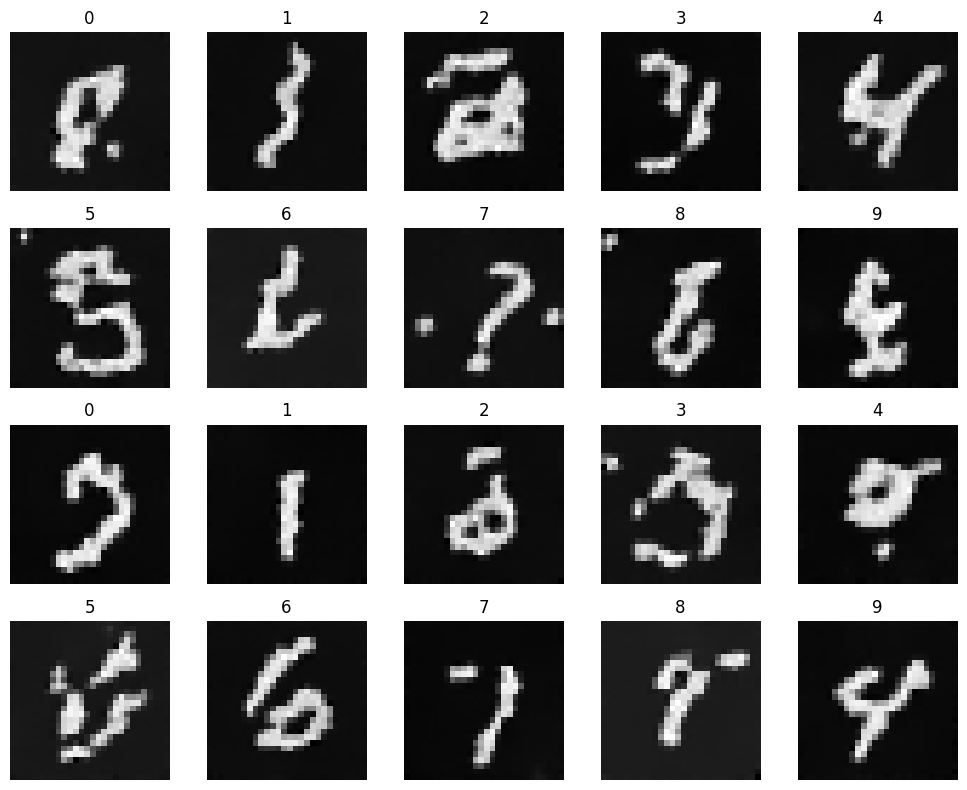

In [288]:
n_cols = int(np.ceil(np.sqrt(n_samples)))
n_rows = int(np.ceil(n_samples / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for i, ax in enumerate(axs.flat):
  if i < n_samples:
    y = sample_classes[i]
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.set_title(y)
    ax.axis('off')

plt.tight_layout()
plt.show()